Most common supervised learning tasks are regression and classification. Ch2 was a general regression taks to predict prices.

### MNIST

MNIST dataset is a set of 70,000 small images of digits hand drawn. Each image is labeled with the digit it represents. This is sometimes known as "hello world" in ML.
Scikit-Learn already have many helper function to popular datasets.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

/Users/smk/dev/ml-ai/.venv/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn have similar structures
* A `DESCR` key describing the dataset
* A `data` key containing an array with one row per instance and one column per features
* A `target` key containing an array with labels

In [19]:
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)
# 70000 images with 784 features

(70000, 784)
(70000,)


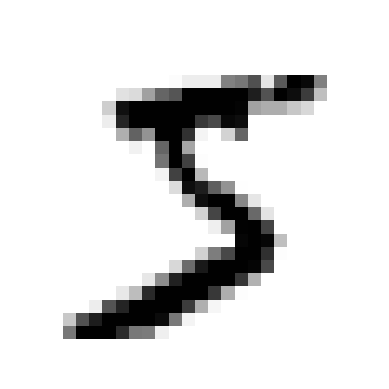

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28,28)    # 784 features are made into 28x28 image

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [25]:
y[0]    # check the label
# note : label is a string convert it to a number

'5'

In [26]:
import numpy as np
y = y.astype(np.uint8)

In [28]:
# since mnist dataset it already split in 
# training set (first 60k images) and test set(last 10k images)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# note this training set is already shuffled for us, which is good and guarantees all
# cross-validation folds are similar

### Training a Binary Classifier
Start smaller with solving the problem to detect only number 5. This 5-detector will be a binary classifier, capable of distinguishing b/t just two classes 5 or not-5



In [29]:
y_train_5 = (y_train == 5) # true for all 5s, false for all other values
y_test_5 = (y_test == 5)

# let's pick a classifier and train it. A good place to start a 
# Stochastic(random) Gradient Descent (SGD) classifier, it provides capability of handling large
# datasets efficiently

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [30]:
sgd_clf.predict([some_digit])   # identifies correctly

/Users/smk/dev/ml-ai/.venv/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Performance Measure

Evaluating a classifier is often significantly trickier than evaluating a regressor, so it little complicated

#### Measuring Accuracy Using Cross-Validation
Usually sometimes we need to implement our own cross-validation code. Following example is similar to Scikit's `cross_val_score()` function

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    # Use iloc for integer-based indexing
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [33]:
# using cross_val_scores() to evaluate SDGClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [34]:
# wow accuracy of 93% but lets's once cross-validate from a dumb classifier 
# that just classifies every single image in "not-5" class

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy thats wierd doesn't it. This is simply because only 10% of the images are 5s so if you always guess not-5 you will be right about 90% of the times :)

Accuracy is not preferred performance measure for classifiers

#### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. General idea is to count the number of times instances of class A are classified as class B. For example, to know number of times the classifier confused image of 5s with 3s, you would look in the (5,3) of confusion matrix.



![Confusion Matrix](./assets/images/ch3_confusion_matrix.png)
